In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/")

### A

In [19]:
from zillow import features,config,info
reload (info)

<module 'zillow.info' from '../python/zillow/info.py'>

In [34]:
def error(yhat,y):
    yhat=np.log(yhat)
    y=np.log(y)
    e=np.abs(yhat-y)
    l1=np.mean(e)
    e[e>0.4]=0.4
    return float(np.mean(e)),float(l1)

In [55]:
def run(state,year,prefix):
    filename=os.path.join(config.get_state_year_folder2(state,year),'combined_{}_prediciton.parq'.format(prefix))
    df=dd.read_parquet(filename).compute()
    df=df[~df['saleprice'].isnull()]
    df.month=df.month.astype(int)+year*100 
    
    if prefix in ['woofinal', 'final']:
        price_col_name='yb_{}_zip5_saleprice'.format(year)
    else:
        price_col_name='yb_{}_model_saleprice'.format(year)
        
    def add_zip(df):
        df2 = features.make_block_dict(state)
        df['rawcensustractandblock'] = df.index.map(lambda u: df2[u])
        df['tract'] = df['rawcensustractandblock'].map(lambda u: u[:11])

        df2 =features. make_county_dict(state)
        df['county'] = df.index.map(lambda u: df2[u])

        df2 = features.make_zip5_dict(state)
        df['zip5'] = df.index.map(lambda u: df2[u])
        df['zip3'] = df['zip5'].map(lambda u: u[:3])
        return df
    df=add_zip(df)
    df.head()
    if prefix in ['woofinal', 'final']:
        hpiobj = info.HpiDiscount('zip5')
    else:
        hpiobj = info.HpiDiscount('modelext')
    def f(u):
        county, zip3, zip5, block, month1 = u
        month0=year*100+1
        return hpiobj.ratio(month0, month1, state, county, zip3, zip5, block)
    df['ratio'] = df[["county", 'zip3', 'zip5', 'rawcensustractandblock',  'month']].apply(f, axis=1)
    for col in [u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']:
        print col, error(df[col].values, df[price_col_name].values)
    print "with raw"
    for col in [u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']:
        print col, error(df[col].values*df['ratio'], df.saleprice.values)

    def g(subdf):
        _,u,v=subdf.values.T
        return error(u,v)[0]
    lst=[]
    for col in [u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']:

        a=df[['month',col, price_col_name]].groupby(['month']).apply(g).to_frame()
        lst.append(a)
    a=pd.concat(lst,axis=1)
    a.columns=[u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']
    display(a)
    a.plot(kind='bar')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()


06 2017 final
meanpred (0.09081242978572845, 0.10350774228572845)
medianpred (0.09077289700508118, 0.10338682681322098)
geomeanpred (0.09082753211259842, 0.10354149341583252)
optimizedpred (0.0906556248664856, 0.10313796997070312)
with raw
meanpred (0.0908098526736396, 0.10350693629326234)
medianpred (0.09077077954893067, 0.10338635703123307)
geomeanpred (0.09082492197628728, 0.10354068088697868)
optimizedpred (0.09065376769266076, 0.10313765967530578)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.090727    0.090741     0.090719       0.090762
201702  0.094972    0.094936     0.095004       0.094845
201703  0.087787    0.087739     0.087763       0.087732
201704  0.087962    0.087771     0.088027       0.087716
201705  0.087069    0.087091     0.087070       0.087043
201706  0.087514    0.087335     0.087505       0.087245
201707  0.088541    0.088558     0.088570       0.088447
201708  0.088853    0.088842     0.088854       0.088746
201709  0.088074    0.088195     0.088092       0.088168
201710  0.091973    0.091843     0.092024       0.091525
201711  0.096727    0.096749     0.096742       0.096515
201712  0.106405    0.106377     0.106426       0.106032

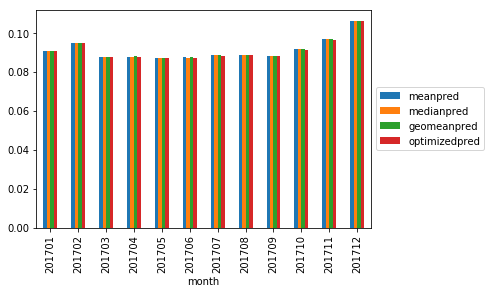


19 2017 final
meanpred (0.11710809171199799, 0.16120928525924683)
medianpred (0.11703520268201828, 0.1608401983976364)
geomeanpred (0.1170945093035698, 0.16092784702777863)
optimizedpred (0.11698427051305771, 0.1601966768503189)
with raw
meanpred (0.11711271712126928, 0.1612188577638092)
medianpred (0.11703883084246602, 0.16084850726334673)
geomeanpred (0.11709781303775478, 0.16093590764114535)
optimizedpred (0.11698575227957834, 0.16020253892269565)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.115997    0.115832     0.115932       0.115574
201702  0.127758    0.127026     0.127648       0.126851
201703  0.119549    0.119473     0.119507       0.119160
201704  0.106296    0.106043     0.106211       0.105974
201705  0.109476    0.109643     0.109608       0.109810
201706  0.110936    0.110782     0.110901       0.110814
201707  0.111245    0.111096     0.111190       0.111044
201708  0.121010    0.120920     0.121078       0.121320
201709  0.124835    0.124683     0.124757       0.124571
201710  0.113959    0.114374     0.114099       0.114504
201711  0.123199    0.123146     0.123159       0.122897
201712  0.134554    0.134621     0.134489       0.134302

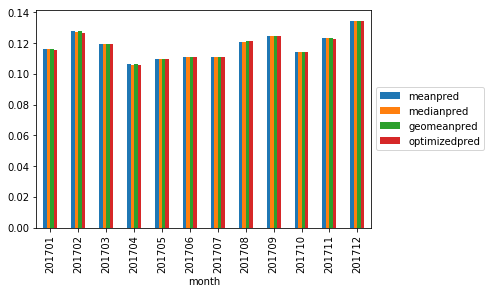


36 2017 final
meanpred (0.13052314519882202, 0.16932520270347595)
medianpred (0.1304788738489151, 0.16914504766464233)
geomeanpred (0.1305895745754242, 0.16951234638690948)
optimizedpred (0.13027742505073547, 0.1689930558204651)
with raw
meanpred (0.13051266136200837, 0.16933012565161223)
medianpred (0.130467353538733, 0.16914977367125203)
geomeanpred (0.13057810766006292, 0.16951612803360183)
optimizedpred (0.13027484430208428, 0.16900671106613002)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.123445    0.123324     0.123510       0.122928
201702  0.130768    0.130743     0.130851       0.130368
201703  0.128079    0.128106     0.128171       0.127809
201704  0.131877    0.131851     0.131858       0.131786
201705  0.138431    0.138374     0.138482       0.138067
201706  0.131990    0.131801     0.131988       0.131891
201707  0.133439    0.133511     0.133568       0.133295
201708  0.126412    0.126259     0.126499       0.126310
201709  0.128641    0.128578     0.128711       0.128329
201710  0.130334    0.130334     0.130371       0.130331
201711  0.133264    0.133400     0.133359       0.132872
201712  0.131432    0.131336     0.131532       0.131129

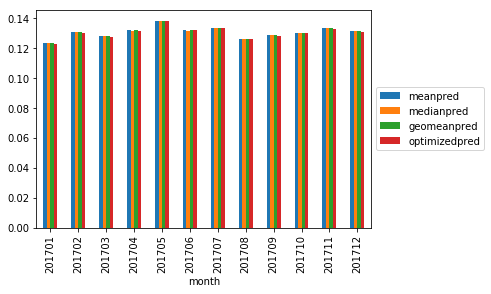


37 2017 final
meanpred (0.12177595496177673, 0.17872978746891022)
medianpred (0.12154927104711533, 0.17770430445671082)
geomeanpred (0.12176589667797089, 0.1782926619052887)
optimizedpred (0.12142156809568405, 0.1772785782814026)
with raw
meanpred (0.12177957388132186, 0.17873262433334489)
medianpred (0.12155431948579999, 0.17770862428949166)
geomeanpred (0.12176961171531923, 0.17829594695231404)
optimizedpred (0.12142656553540442, 0.17728293068145565)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.123618    0.123695     0.123703       0.123655
201702  0.126542    0.126320     0.126603       0.126054
201703  0.117161    0.116796     0.117177       0.116618
201704  0.116599    0.116239     0.116560       0.116157
201705  0.117553    0.117230     0.117558       0.116947
201706  0.115787    0.115390     0.115707       0.115273
201707  0.115835    0.115877     0.115907       0.115804
201708  0.119054    0.118624     0.118912       0.118612
201709  0.120586    0.120707     0.120659       0.120532
201710  0.130477    0.130308     0.130394       0.130194
201711  0.134176    0.133892     0.134135       0.133813
201712  0.132447    0.132211     0.132495       0.132082


39 2017 final
meanpred (0.14485245943069458, 0.22297565639019012)
medianpred (0.1446780264377594, 0.22191698849201202)
geomeanpred (0.14473435282707214, 0.22234608232975006)
optimizedpred (0.1445816308259964, 0.2213200479745865)
with raw
meanpred (0.14485889547070963, 0.22297457829261058)
medianpred (0.14468442187158284, 0.2219163814639225)
geomeanpred (0.14474083153204295, 0.22234528149467628)
optimizedpred (0.14458807439585106, 0.22131997621625302)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.153725    0.153285     0.153582       0.153024
201702  0.155603    0.155224     0.155413       0.155215
201703  0.144549    0.144308     0.144378       0.144077
201704  0.140496    0.140209     0.140323       0.140019
201705  0.136677    0.136396     0.136505       0.136330
201706  0.137036    0.136945     0.136950       0.136883
201707  0.139777    0.139601     0.139756       0.139389
201708  0.140316    0.139967     0.140083       0.139793
201709  0.146614    0.146502     0.146492       0.146337
201710  0.149979    0.149969     0.149924       0.150050
201711  0.152017    0.152242     0.152014       0.152419
201712  0.156285    0.156164     0.156204       0.156094


06 2018 final
meanpred (0.10359272360801697, 0.13070465624332428)
medianpred (0.10353972762823105, 0.13040319085121155)
geomeanpred (0.10364936292171478, 0.13076969981193542)
optimizedpred (0.10353896021842957, 0.13045914471149445)
with raw
meanpred (0.10356433245396741, 0.13066536362968462)
medianpred (0.10351694174636931, 0.1303694466512186)
geomeanpred (0.10362311552468921, 0.13073262567782032)
optimizedpred (0.10350910686974803, 0.13041806206998474)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.107604    0.107690     0.107633       0.107669
201802  0.105764    0.105516     0.105798       0.105672
201803  0.101219    0.101093     0.101301       0.101179
201804  0.102855    0.102884     0.102952       0.102729
201805  0.103374    0.103379     0.103416       0.103305
201806  0.087284    0.087522     0.087168       0.087260

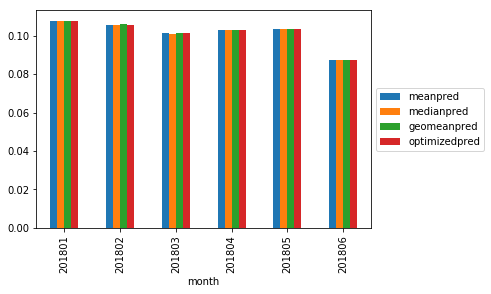


19 2018 final
meanpred (0.11525307595729828, 0.15079191327095032)
medianpred (0.11503099650144577, 0.15008923411369324)
geomeanpred (0.11522258818149567, 0.15058250725269318)
optimizedpred (0.11499301344156265, 0.14977586269378662)
with raw
meanpred (0.11525286232184301, 0.1507875283863389)
medianpred (0.11503138128785453, 0.15008573818382293)
geomeanpred (0.1152224605816347, 0.1505783104280082)
optimizedpred (0.11499165646151448, 0.1497708456226397)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.128213    0.127789     0.128077       0.127710
201802  0.113988    0.113802     0.113865       0.113650
201803  0.111404    0.111122     0.111410       0.111216
201804  0.115025    0.114905     0.115053       0.114799
201805  0.112690    0.112550     0.112676       0.112502
201806  0.105984    0.105619     0.106035       0.105869

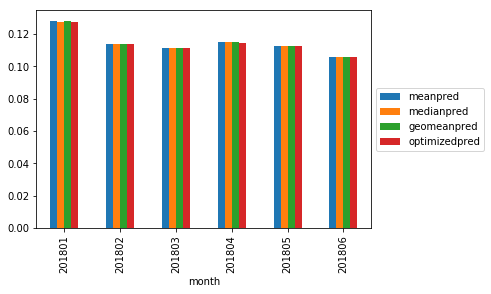


36 2018 final
meanpred (0.13696421682834625, 0.17824795842170715)
medianpred (0.1365320086479187, 0.1773906797170639)
geomeanpred (0.1370391547679901, 0.17848409712314606)
optimizedpred (0.13637889921665192, 0.1770385205745697)
with raw
meanpred (0.1369995040817343, 0.17826030261294393)
medianpred (0.13656851731637615, 0.17740312953032059)
geomeanpred (0.13707473412315557, 0.17849649673136267)
optimizedpred (0.13640586439188393, 0.17703974506852269)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.130596    0.130209     0.130591       0.129926
201802  0.138544    0.137666     0.138609       0.137309
201803  0.139267    0.139041     0.139332       0.139070
201804  0.137916    0.138077     0.138127       0.138091
201805  0.139316    0.138629     0.139365       0.138471
201806  0.138767    0.137996     0.138891       0.137886

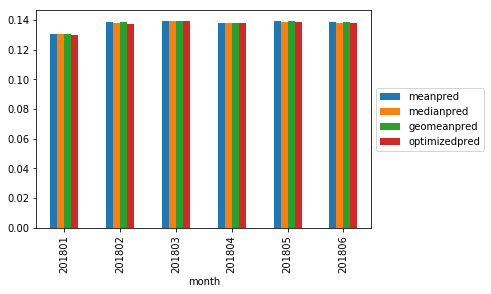


37 2018 final
meanpred (0.12571315467357635, 0.18471091985702515)
medianpred (0.1254301369190216, 0.18265508115291595)
geomeanpred (0.12564930319786072, 0.183515265583992)
optimizedpred (0.12529072165489197, 0.1806207001209259)
with raw
meanpred (0.12568333994820932, 0.18470654245299664)
medianpred (0.1254029985234114, 0.18265021023148087)
geomeanpred (0.12561796541729828, 0.18350820172224036)
optimizedpred (0.1252590473900343, 0.18060680705252974)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.133333    0.132665     0.133190       0.132633
201802  0.131337    0.130851     0.131060       0.130797
201803  0.123533    0.123593     0.123633       0.123546
201804  0.122176    0.121998     0.122221       0.121704
201805  0.121725    0.121403     0.121583       0.121227
201806  0.125538    0.125220     0.125480       0.123760

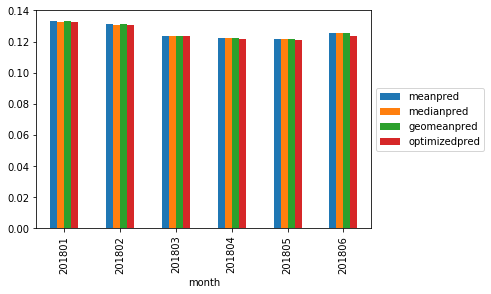


39 2018 final
meanpred (0.15307055413722992, 0.23437267541885376)
medianpred (0.15271849930286407, 0.23284779489040375)
geomeanpred (0.15293553471565247, 0.2335391491651535)
optimizedpred (0.1527264416217804, 0.23165549337863922)
with raw
meanpred (0.15308244285301192, 0.23437467260269546)
medianpred (0.15273201934750077, 0.23285026182777974)
geomeanpred (0.1529473558573028, 0.23354025161009948)
optimizedpred (0.15273990538057694, 0.23165743727912969)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.160100    0.159853     0.159947       0.159862
201802  0.164907    0.164187     0.164700       0.164163
201803  0.154357    0.154380     0.154372       0.154600
201804  0.151086    0.150659     0.150929       0.150500
201805  0.138354    0.137788     0.138124       0.137736
201806  0.136947    0.138444     0.137303       0.138925

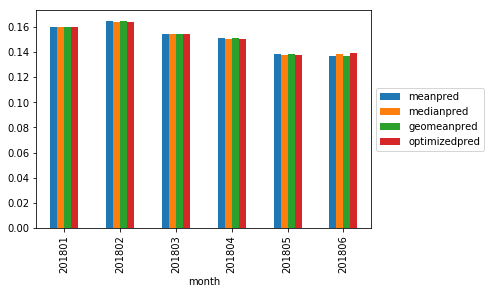

In [53]:
for year in [2017,2018]:
    for state in config.STATES:
        prefix='final'
        print""
        print state, year, prefix
        run(state,year,prefix)


06 2017 woofinal
meanpred (0.090807244181633, 0.10388198494911194)
medianpred (0.09071426093578339, 0.1036994606256485)
geomeanpred (0.09082731604576111, 0.1039215475320816)
optimizedpred (0.09063813090324402, 0.10357260704040527)
with raw
meanpred (0.09080317652453737, 0.10387952637030591)
medianpred (0.09071028582263038, 0.10369717793012123)
geomeanpred (0.09082314056749659, 0.10391904394186811)
optimizedpred (0.09063422861238876, 0.10357036474139546)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.090788    0.090765     0.090778       0.090731
201702  0.095266    0.095183     0.095280       0.095149
201703  0.087744    0.087545     0.087754       0.087507
201704  0.087926    0.087801     0.087984       0.087751
201705  0.087216    0.087181     0.087222       0.087098
201706  0.087248    0.087048     0.087243       0.086955
201707  0.088582    0.088599     0.088613       0.088504
201708  0.088897    0.088809     0.088902       0.088677
201709  0.088062    0.088109     0.088067       0.088016
201710  0.091971    0.091806     0.092016       0.091722
201711  0.096729    0.096613     0.096781       0.096520
201712  0.106270    0.106166     0.106300       0.106148

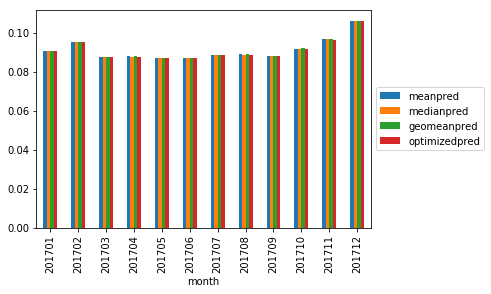


19 2017 woofinal
meanpred (0.11694777756929398, 0.16224460303783417)
medianpred (0.11679448187351227, 0.1618058979511261)
geomeanpred (0.11693894863128662, 0.16213400661945343)
optimizedpred (0.11672685295343399, 0.16121071577072144)
with raw
meanpred (0.11695576040852908, 0.16225799954804918)
medianpred (0.11680237713503214, 0.16181869845359348)
geomeanpred (0.11694664197832272, 0.1621470389872965)
optimizedpred (0.11672927943884943, 0.16121766905551108)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.116233    0.115959     0.116194       0.115513
201702  0.126523    0.125995     0.126486       0.125413
201703  0.120159    0.120096     0.120136       0.119732
201704  0.106225    0.106136     0.106187       0.106033
201705  0.109134    0.109162     0.109197       0.109598
201706  0.110481    0.110202     0.110461       0.110151
201707  0.111632    0.111516     0.111580       0.111405
201708  0.120284    0.120045     0.120310       0.120105
201709  0.124261    0.124001     0.124225       0.123939
201710  0.112981    0.113067     0.113060       0.113436
201711  0.123155    0.122920     0.123134       0.122580
201712  0.135353    0.135334     0.135329       0.135319

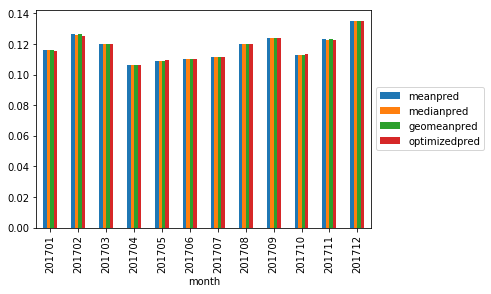


36 2017 woofinal
meanpred (0.13050401210784912, 0.17139080166816711)
medianpred (0.13026589155197144, 0.1709880232810974)
geomeanpred (0.13047170639038086, 0.17144910991191864)
optimizedpred (0.1303882896900177, 0.17064732313156128)
with raw
meanpred (0.13050430223287993, 0.17140699121470054)
medianpred (0.13026592387919245, 0.17100408193538752)
geomeanpred (0.13047114501136614, 0.1714643576434813)
optimizedpred (0.130376919692059, 0.17065164629388452)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.122912    0.122740     0.122902       0.122982
201702  0.130700    0.130720     0.130739       0.130819
201703  0.127527    0.127226     0.127484       0.127503
201704  0.131623    0.131438     0.131622       0.131579
201705  0.139396    0.138905     0.139326       0.138698
201706  0.131686    0.131213     0.131667       0.131312
201707  0.135028    0.134784     0.135024       0.134981
201708  0.127770    0.127594     0.127730       0.127441
201709  0.127695    0.127291     0.127718       0.127616
201710  0.129633    0.129484     0.129538       0.129473
201711  0.132861    0.132746     0.132807       0.133046
201712  0.130886    0.130771     0.130783       0.130947

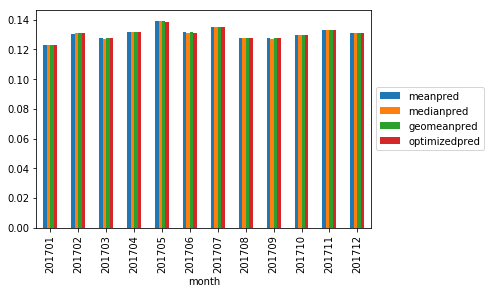


37 2017 woofinal
meanpred (0.12121975421905518, 0.17983290553092957)
medianpred (0.12095105648040771, 0.1790541410446167)
geomeanpred (0.12120744585990906, 0.1796155869960785)
optimizedpred (0.12078016251325607, 0.1784740388393402)
with raw
meanpred (0.12122137089374568, 0.1798348435314602)
medianpred (0.12095319604922754, 0.17905687867421083)
geomeanpred (0.12120918927613554, 0.17961768593460256)
optimizedpred (0.12078433545763922, 0.17847846257784353)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.122701    0.122658     0.122735       0.122836
201702  0.126081    0.125860     0.126141       0.125917
201703  0.116669    0.116345     0.116707       0.116200
201704  0.116226    0.115769     0.116179       0.115241
201705  0.117070    0.116778     0.117069       0.116384
201706  0.115387    0.114928     0.115314       0.114482
201707  0.115188    0.115106     0.115249       0.115115
201708  0.118262    0.117865     0.118141       0.117897
201709  0.120037    0.119930     0.120058       0.119939
201710  0.130052    0.129859     0.130030       0.129673
201711  0.133642    0.133447     0.133638       0.133194
201712  0.131718    0.131428     0.131694       0.131300

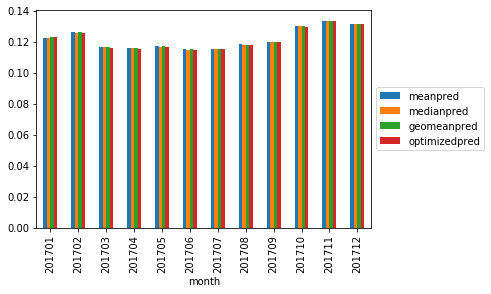


39 2017 woofinal
meanpred (0.14439161121845245, 0.22416460514068604)
medianpred (0.14412237703800201, 0.22319428622722626)
geomeanpred (0.1442660242319107, 0.22367845475673676)
optimizedpred (0.14404809474945068, 0.2225543111562729)
with raw
meanpred (0.1443956181031447, 0.2241599741740946)
medianpred (0.14412620281653651, 0.22318995888200546)
geomeanpred (0.14427005906943588, 0.22367411518485805)
optimizedpred (0.14405710180519957, 0.22255547167784479)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.153074    0.152865     0.152980       0.153000
201702  0.155450    0.154880     0.155247       0.154960
201703  0.144483    0.143998     0.144316       0.143562
201704  0.140145    0.139623     0.139890       0.139467
201705  0.136475    0.136341     0.136366       0.136133
201706  0.136631    0.136315     0.136499       0.136327
201707  0.139078    0.138910     0.139034       0.138681
201708  0.139658    0.139169     0.139415       0.139040
201709  0.146381    0.146165     0.146273       0.146131
201710  0.149384    0.149354     0.149331       0.149527
201711  0.151457    0.151397     0.151428       0.151495
201712  0.155438    0.155288     0.155352       0.155206

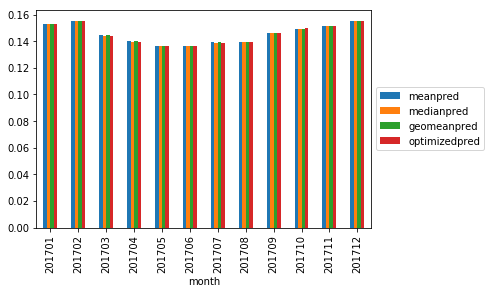


06 2018 woofinal
meanpred (0.10339001566171646, 0.13215050101280212)
medianpred (0.1033099815249443, 0.1319277584552765)
geomeanpred (0.10342258960008621, 0.13221681118011475)
optimizedpred (0.10335525870323181, 0.13200721144676208)
with raw
meanpred (0.10333889664869954, 0.13208852656724607)
medianpred (0.10326350468565092, 0.13187023004571102)
geomeanpred (0.10337300343512604, 0.1321570272787426)
optimizedpred (0.10331557575576358, 0.13195660282986035)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.107534    0.107521     0.107530       0.107277
201802  0.105501    0.105279     0.105510       0.105286
201803  0.100807    0.100731     0.100855       0.100795
201804  0.102429    0.102418     0.102505       0.102741
201805  0.103727    0.103662     0.103751       0.103716
201806  0.086833    0.086615     0.086824       0.086363

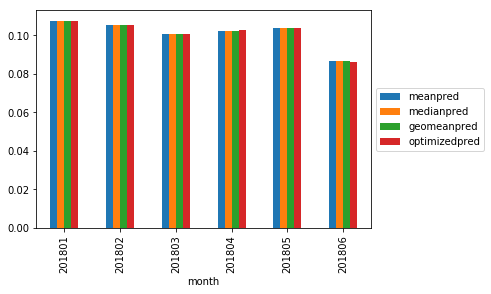


19 2018 woofinal
meanpred (0.1161213368177414, 0.15263639390468597)
medianpred (0.11584202200174332, 0.15201398730278015)
geomeanpred (0.11612091213464737, 0.15257258713245392)
optimizedpred (0.11595620959997177, 0.15209680795669556)
with raw
meanpred (0.11611177990142027, 0.15262321393161343)
medianpred (0.11583264117054153, 0.15200075810340008)
geomeanpred (0.11611204200452568, 0.15256011800323274)
optimizedpred (0.11594928458106134, 0.15208598541813897)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.129691    0.129295     0.129629       0.129175
201802  0.114440    0.114236     0.114435       0.114481
201803  0.113198    0.112928     0.113192       0.112895
201804  0.115583    0.115312     0.115641       0.115637
201805  0.113056    0.112816     0.113047       0.112955
201806  0.105946    0.105515     0.105968       0.105571

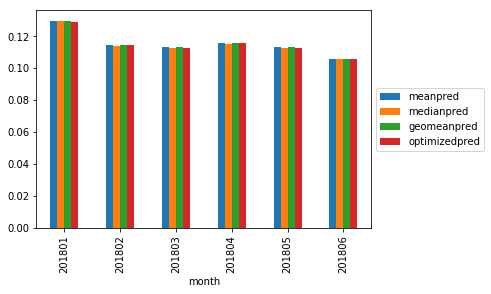


36 2018 woofinal
meanpred (0.13673806190490723, 0.1799488663673401)
medianpred (0.13614365458488464, 0.17889051139354706)
geomeanpred (0.13668321073055267, 0.1799558848142624)
optimizedpred (0.13620086014270782, 0.17853085696697235)
with raw
meanpred (0.13675873546818043, 0.17994972043537782)
medianpred (0.13617175592562186, 0.17889891554566076)
geomeanpred (0.13670256334663064, 0.17995700264969078)
optimizedpred (0.13624013198704651, 0.17855096171812826)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.129179    0.128768     0.129102       0.129060
201802  0.138429    0.137289     0.138336       0.137517
201803  0.139814    0.139497     0.139727       0.139385
201804  0.137932    0.137867     0.138018       0.137883
201805  0.139375    0.138376     0.139276       0.138410
201806  0.138670    0.137884     0.138642       0.137414

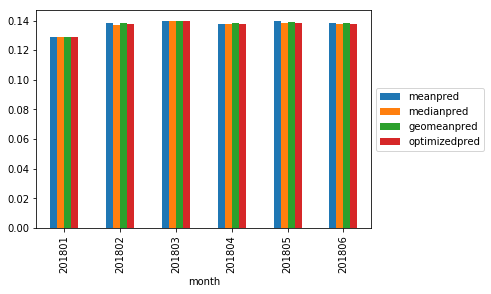


37 2018 woofinal
meanpred (0.12552429735660553, 0.18647244572639465)
medianpred (0.12534861266613007, 0.18519806861877441)
geomeanpred (0.1255066841840744, 0.18616455793380737)
optimizedpred (0.1252361238002777, 0.18392780423164368)
with raw
meanpred (0.12550471526035412, 0.18647993543556443)
medianpred (0.12532658390296536, 0.18520221938091302)
geomeanpred (0.12548604270481648, 0.1861705422038373)
optimizedpred (0.12519690110381118, 0.1839142313976104)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.133269    0.132817     0.133216       0.132591
201802  0.131249    0.131106     0.131166       0.131090
201803  0.123444    0.123366     0.123488       0.123270
201804  0.121314    0.121234     0.121313       0.121311
201805  0.121969    0.121792     0.121953       0.121488
201806  0.126694    0.125771     0.126335       0.124798


39 2018 woofinal
meanpred (0.15252704918384552, 0.23497937619686127)
medianpred (0.152325838804245, 0.23395058512687683)
geomeanpred (0.15248897671699524, 0.23469945788383484)
optimizedpred (0.15243522822856903, 0.23301084339618683)
with raw
meanpred (0.15254949018407632, 0.23499119282628952)
medianpred (0.15234333968694608, 0.2339596327838156)
geomeanpred (0.1525109472096397, 0.23471100087481567)
optimizedpred (0.15244443491040952, 0.2330078193367074)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.159577    0.159363     0.159518       0.159534
201802  0.164103    0.163621     0.164028       0.163463
201803  0.153785    0.153686     0.153779       0.153788
201804  0.150735    0.150653     0.150704       0.150876
201805  0.137680    0.137440     0.137638       0.137595
201806  0.142241    0.143046     0.142395       0.143065

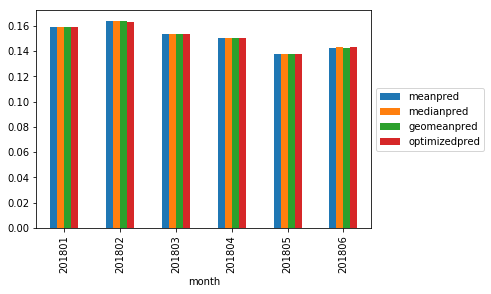

In [54]:
for year in [2017,2018]:
    for state in config.STATES:
        prefix='woofinal'
        print""
        print state, year, prefix
        run(state,year,prefix)


06 2017 woomodelhpifinal
meanpred (0.0899868831038475, 0.1030561700463295)
medianpred (0.08989360928535461, 0.10287269204854965)
geomeanpred (0.09000706672668457, 0.10309725254774094)
optimizedpred (0.08977320790290833, 0.1026216521859169)
with raw
meanpred (0.08998323077424261, 0.10305362511438464)
medianpred (0.08988994151885862, 0.10287033811065512)
geomeanpred (0.09000338151488779, 0.10309474486402469)
optimizedpred (0.08976956596427281, 0.10261933703587002)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.090220    0.090145     0.090201       0.090017
201702  0.094411    0.094328     0.094414       0.094225
201703  0.086719    0.086506     0.086740       0.086367
201704  0.087292    0.087140     0.087338       0.087008
201705  0.086549    0.086495     0.086567       0.086390
201706  0.086942    0.086760     0.086944       0.086609
201707  0.088273    0.088277     0.088292       0.088139
201708  0.088684    0.088617     0.088697       0.088475
201709  0.087883    0.087961     0.087892       0.087913
201710  0.090826    0.090653     0.090867       0.090523
201711  0.095102    0.094995     0.095150       0.094856
201712  0.103248    0.103173     0.103278       0.103111

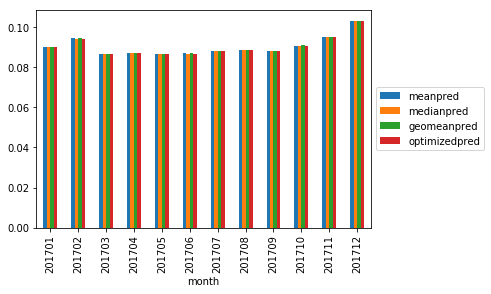


19 2017 woomodelhpifinal
meanpred (0.11692014336585999, 0.16221411526203156)
medianpred (0.11674420535564423, 0.16171948611736298)
geomeanpred (0.1169082522392273, 0.16208912432193756)
optimizedpred (0.11670936644077301, 0.1611255407333374)
with raw
meanpred (0.11693331804365704, 0.162225551548785)
medianpred (0.11675733014843738, 0.16173074612221588)
geomeanpred (0.11692141863199261, 0.16210056110729884)
optimizedpred (0.11672170977670443, 0.16113603848557093)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.116334    0.115995     0.116279       0.115338
201702  0.126261    0.125606     0.126208       0.124918
201703  0.119553    0.119375     0.119540       0.119356
201704  0.106012    0.105895     0.105969       0.105503
201705  0.108930    0.108979     0.108993       0.109241
201706  0.110333    0.110084     0.110293       0.109984
201707  0.111552    0.111342     0.111493       0.111384
201708  0.120829    0.120611     0.120844       0.120702
201709  0.124614    0.124395     0.124588       0.124482
201710  0.113149    0.113229     0.113236       0.113689
201711  0.123118    0.122948     0.123123       0.122934
201712  0.135521    0.135377     0.135480       0.135416

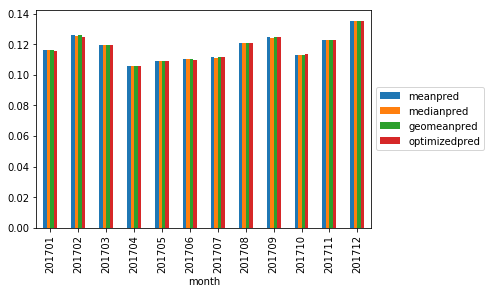


36 2017 woomodelhpifinal
meanpred (0.13075673580169678, 0.17155244946479797)
medianpred (0.1305931806564331, 0.1712452620267868)
geomeanpred (0.13074296712875366, 0.17162249982357025)
optimizedpred (0.1306900531053543, 0.17090120911598206)
with raw
meanpred (0.13075188817922473, 0.17154395688454308)
medianpred (0.13058946131795718, 0.17123785104569808)
geomeanpred (0.13073818941079823, 0.1716140759770285)
optimizedpred (0.13068903486126374, 0.1708966359889671)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.124205    0.124063     0.124097       0.123453
201702  0.131471    0.131373     0.131420       0.130928
201703  0.128054    0.127687     0.127991       0.127305
201704  0.131987    0.131759     0.131945       0.131443
201705  0.139146    0.138845     0.139080       0.138598
201706  0.131281    0.130907     0.131314       0.130945
201707  0.135152    0.134976     0.135196       0.135451
201708  0.127537    0.127568     0.127599       0.127876
201709  0.127715    0.127373     0.127758       0.127934
201710  0.130130    0.130187     0.130117       0.130778
201711  0.133396    0.133345     0.133371       0.133887
201712  0.130845    0.130855     0.130832       0.131268


37 2017 woomodelhpifinal
meanpred (0.12087808549404144, 0.17964529991149902)
medianpred (0.12059074640274048, 0.17872931063175201)
geomeanpred (0.12085920572280884, 0.17936912178993225)
optimizedpred (0.12044466286897659, 0.1781977117061615)
with raw
meanpred (0.12087637515139824, 0.1796438087441207)
medianpred (0.12058875454287415, 0.17872772467007259)
geomeanpred (0.1208574834821012, 0.17936757446660653)
optimizedpred (0.12044222065124605, 0.17819584836992716)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.121091    0.120938     0.121060       0.120764
201702  0.124925    0.124655     0.124917       0.124436
201703  0.116181    0.115787     0.116215       0.115558
201704  0.115323    0.114881     0.115299       0.114707
201705  0.116826    0.116527     0.116829       0.116334
201706  0.115255    0.114786     0.115193       0.114571
201707  0.115117    0.115058     0.115162       0.114932
201708  0.118232    0.117780     0.118092       0.117762
201709  0.119908    0.119791     0.119901       0.119665
201710  0.130120    0.129965     0.130118       0.129880
201711  0.133622    0.133383     0.133629       0.133220
201712  0.131478    0.131205     0.131464       0.131157

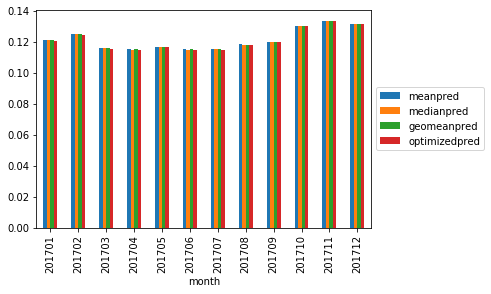


39 2017 woomodelhpifinal
meanpred (0.14421309530735016, 0.22396345436573029)
medianpred (0.14393723011016846, 0.22296994924545288)
geomeanpred (0.14409439265727997, 0.22347764670848846)
optimizedpred (0.14389139413833618, 0.22241102159023285)
with raw
meanpred (0.14421149627013483, 0.22396053479411235)
medianpred (0.14393577046401398, 0.2229672800981398)
geomeanpred (0.14409275470068209, 0.2234746493057657)
optimizedpred (0.1438894443510852, 0.2224080368772665)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201701  0.152144    0.151810     0.152010       0.151437
201702  0.154564    0.154127     0.154433       0.153875
201703  0.143973    0.143489     0.143851       0.143166
201704  0.139867    0.139364     0.139600       0.139338
201705  0.136127    0.136018     0.136043       0.136023
201706  0.136648    0.136360     0.136524       0.136414
201707  0.139345    0.139168     0.139325       0.139068
201708  0.139632    0.139139     0.139396       0.139179
201709  0.146481    0.146221     0.146362       0.146303
201710  0.149240    0.149146     0.149174       0.149248
201711  0.151310    0.151269     0.151284       0.151373
201712  0.155347    0.155142     0.155245       0.154930

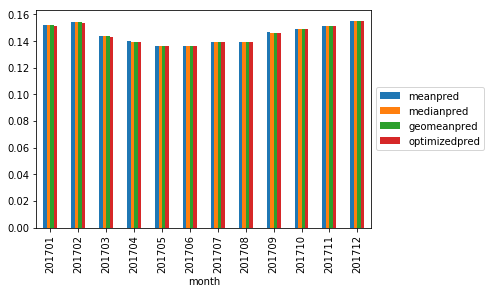


06 2018 woomodelhpifinal
meanpred (0.10240855813026428, 0.13106922805309296)
medianpred (0.10234182327985764, 0.13086679577827454)
geomeanpred (0.10244190692901611, 0.13113561272621155)
optimizedpred (0.10235297679901123, 0.13091911375522614)
with raw
meanpred (0.10241142244296897, 0.13106970668912912)
medianpred (0.10234510190804148, 0.13086769173251658)
geomeanpred (0.1024448183512262, 0.13113611897922225)
optimizedpred (0.10235608886057893, 0.13091983368087307)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.106099    0.106097     0.106103       0.106017
201802  0.104793    0.104626     0.104816       0.104687
201803  0.100444    0.100395     0.100495       0.100421
201804  0.100267    0.100235     0.100311       0.100245
201805  0.103385    0.103312     0.103422       0.103334
201806  0.085818    0.085582     0.085824       0.085634

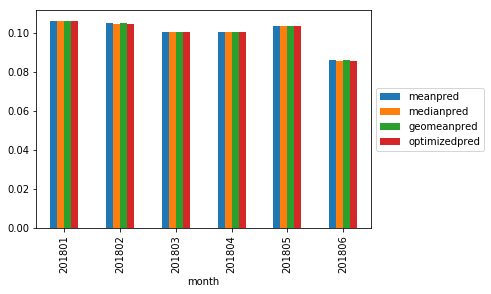


19 2018 woomodelhpifinal
meanpred (0.11605890095233917, 0.1525501012802124)
medianpred (0.11579196155071259, 0.15197187662124634)
geomeanpred (0.11605703830718994, 0.15248766541481018)
optimizedpred (0.11590396612882614, 0.15202458202838898)
with raw
meanpred (0.11605739198483428, 0.15254533369590056)
medianpred (0.11579155361349155, 0.15196799917124054)
geomeanpred (0.11605625171354507, 0.15248379302688048)
optimizedpred (0.11590373949339867, 0.15202087694798921)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.130151    0.129743     0.130067       0.129527
201802  0.114236    0.114021     0.114198       0.114002
201803  0.112497    0.112332     0.112511       0.112416
201804  0.115340    0.115066     0.115404       0.115304
201805  0.113313    0.113051     0.113303       0.113278
201806  0.106478    0.106061     0.106511       0.106555


36 2018 woomodelhpifinal
meanpred (0.13648070394992828, 0.17965416610240936)
medianpred (0.13588005304336548, 0.17858172953128815)
geomeanpred (0.13643139600753784, 0.17967091500759125)
optimizedpred (0.1360313892364502, 0.17835646867752075)
with raw
meanpred (0.13648179815362707, 0.17965402037368972)
medianpred (0.13588104577645532, 0.17858150675809253)
geomeanpred (0.13643249301558355, 0.17967076863205825)
optimizedpred (0.13603283020047377, 0.17835667775849048)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.128795    0.128315     0.128685       0.128397
201802  0.138054    0.137074     0.137959       0.137096
201803  0.139347    0.138997     0.139275       0.139317
201804  0.137700    0.137612     0.137756       0.137556
201805  0.139332    0.138407     0.139281       0.138721
201806  0.139013    0.137933     0.139078       0.138228


37 2018 woomodelhpifinal
meanpred (0.1252344399690628, 0.18633373081684113)
medianpred (0.1250181943178177, 0.18485333025455475)
geomeanpred (0.12521356344223022, 0.1859630048274994)
optimizedpred (0.12499304115772247, 0.1838642656803131)
with raw
meanpred (0.12523085225718605, 0.18632797427549425)
medianpred (0.1250150844674051, 0.18484789731813211)
geomeanpred (0.12521015109306807, 0.18595752160636997)
optimizedpred (0.12499022137757784, 0.18385909370506373)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.132964    0.132379     0.132867       0.131875
201802  0.131113    0.130935     0.131020       0.130877
201803  0.123225    0.123141     0.123268       0.123171
201804  0.121006    0.120893     0.121004       0.121090
201805  0.121505    0.121307     0.121517       0.121386
201806  0.126628    0.125777     0.126270       0.125328

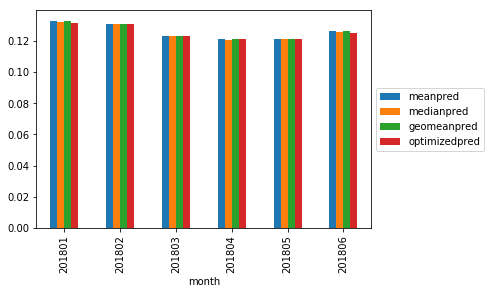


39 2018 woomodelhpifinal
meanpred (0.15237924456596375, 0.2347477227449417)
medianpred (0.1521906554698944, 0.23375940322875977)
geomeanpred (0.1523459106683731, 0.23447924852371216)
optimizedpred (0.15219268202781677, 0.23283372819423676)
with raw
meanpred (0.15237694948585911, 0.23474506519710184)
medianpred (0.15218830331610644, 0.23375673519628873)
geomeanpred (0.15234360839484998, 0.23447658164631674)
optimizedpred (0.15219030642797512, 0.23283107484713178)


meanpred  medianpred  geomeanpred  optimizedpred
month                                                   
201801  0.159377    0.159176     0.159318       0.159226
201802  0.163911    0.163505     0.163853       0.163140
201803  0.153584    0.153536     0.153587       0.153648
201804  0.150496    0.150376     0.150455       0.150344
201805  0.137708    0.137447     0.137677       0.137587
201806  0.144792    0.145295     0.144953       0.145955

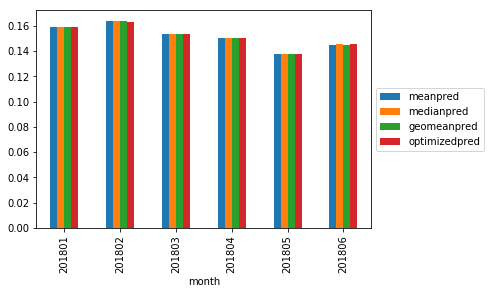

In [59]:
for year in [2017,2018]:
    for state in config.STATES:
        prefix='woomodelhpifinal'
        print""
        print state, year, prefix
        run(state,year,prefix)

In [58]:
reload(info)

<module 'zillow.info' from '../python/zillow/info.py'>